In [152]:
# A prototype / scratch book for testing things related to NLP
# on the puzzle review data
import numpy as np
import pandas as pd
import glob
import psycopg2
import nlp_tools
from importlib import reload
reload(nlp_tools)

<module 'nlp_tools' from '/Users/cheetham/Dropbox/insight/ideas/jigsaw/nlp_tools.py'>

In [135]:
# Connect to the database we'll use
conn = nlp_tools.connect_to_db()

Connected to database


In [104]:
# Get all reviews from the database
all_reviews = nlp_tools.get_reviews(conn)
all_text_string = ''
for a in all_reviews:
    all_text_string+=a[0]
print('Characters:',len(all_text_string))
print('Words:',len(all_text_string.split(' ')))
print('Sentences:',len(all_text_string.split('.')))

Characters: 13827128
Words: 2493531
Sentences: 197517


In [105]:
# How long are the reviews per puzzle?
cursor = conn.cursor()
all_reviews = []
n_reviews_per_product = []
n_words = []
for ix in range(6989):
    rev = nlp_tools.get_reviews(conn,product_index=ix+1)
    n_reviews_per_product.append(len(rev))
    # Append them all to one string
    bigstring = ''
    for a in rev:
        bigstring+=a[0]
    bigstring = bigstring.replace('.','. ').replace('  ',' ')
    n_words.append(len(bigstring.split(' ')))        
    all_reviews.append(bigstring)

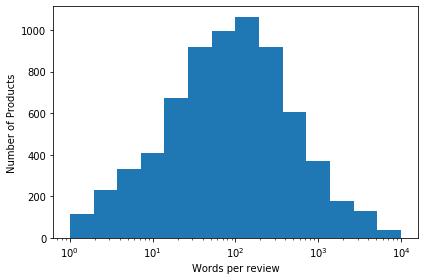

In [106]:
import matplotlib.pyplot as plt
bins = np.logspace(0,4,num=15)
plt.hist(n_words,bins=bins)
plt.xlabel('Words per review')
plt.ylabel('Number of Products')
plt.xscale('log')
plt.tight_layout()
# plt.show()
# plt.savefig('words_per_review.png')

In [107]:
# Try word2vec with gensim
from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 
  
import gensim 
from gensim.models import Word2Vec

In [108]:
### Using the Google News pre-trained Word2Vec model to convert words 
# into vectors (with Gensim):

from gensim.models import KeyedVectors
# Load vectors directly from the file
model = KeyedVectors.load_word2vec_format('/Users/cheetham/Dropbox/insight/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [161]:
# Try it on a review
import scipy
import nltk
all_product_urls = np.loadtxt('1000_piece/product_urls.txt',dtype=str)

print(len(all_product_urls))
n = 500
print(all_product_urls[n])
print(all_reviews[n][0:50])
review = all_reviews[n]
review = nlp_tools.clean_tokenize_stops(review)
vect = nlp_tools._evaluate(review,use_model=model)
# print(model['difficult'])

search_term = 'Difficult'
clean_search_term = nlp_tools.clean_tokenize_stops(search_term)

vect2 = nlp_tools._evaluate(clean_search_term,use_model=model)
comparator = scipy.spatial.distance.cosine

print(comparator(vect,vect2))

6990
https://amazon.com/4D-Cityscape-Game-Thrones-Westeros/dp/B00DLX51HK
The colors and layout of this puzzle were wonderfu
0.575036495923996


In [118]:
# Prototype on all reviews!
import scipy
all_product_urls = np.loadtxt('1000_piece/product_urls.txt',dtype=str)

# Prepare the reviews
n_reviews = len(all_reviews)
print(n_reviews)
rev_vects = []
clean_revs = []
for r_ix in range(n_reviews):
    clean_rev = clean(all_reviews[r_ix])
    clean_revs.extend(clean_rev)
    if (len(clean_rev) > 50) and (n_reviews_per_product[r_ix] > 50):
        vect = _evaluate(clean_rev)
        rev_vects.append(vect)
    else:
        rev_vects.append(np.repeat(np.nan,300))

6989


In [159]:
# Try training a new model on this as well
sentences = []
for r in all_reviews:
    if len(r) == 0:
        continue
    clean_sentences = r.split('.')
    for c in clean_sentences:
        if len(c.strip()) > 5:
            x = c.strip().lower().replace('puzzle','').replace('white mountain','')
            x = x.replace('ravensburger','')
            sentences.append(x)

print('Training with {0} sentences'.format(len(sentences)))
# my_model = gensim.models.Word2Vec(clean_revs, min_count = 1,  
#                               size = 100, window = 5)
# print('Done')

# # Import the wordcloud library
# from wordcloud import WordCloud
# # Join the different processed titles together.
# long_string = ','.join(sentences)
# # Create a WordCloud object
# wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')
# # Generate a word cloud
# wordcloud.generate(long_string)
# # Visualize the word cloud
# wordcloud.to_image()

Training with 184100 sentences


In [158]:
# print(sentences[800:802])
phrase = sentences[800]
step1 = nlp_tools.clean(phrase)
step2 = nlp_tools.tokenize(step1)
step3 = nlp_tools.remove_stops(step2)
print(step1)
print(step2)
print(step3)

i used this product on vacation when we always do s
['i', 'used', 'this', 'product', 'on', 'vacation', 'when', 'we', 'always', 'do', 's']
['used', 'product', 'vacation', 'always']


In [119]:
# Try LDA
# Load the LDA model from sk-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(sentences)
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
love loved gift recommend bought loves working doing perfect frame

Topic #1:
like time box buy took ve just picture brand finish

Topic #2:
pieces piece missing fit cut like box shapes don sturdy

Topic #3:
quality good really challenge great fun nice enjoyed hard challenging

Topic #4:
fun great beautiful challenging colors love family picture looks just


Best matches:
['https://amazon.com/MasterPieces-Accessories-Pieces-Puzzles-Included/dp/B0006H1BGY'
 'https://amazon.com/Bits-Pieces-Mystery-Bedford-Dieckhoner/dp/B005OKBR9O'
 'https://amazon.com/Star-Wars-Photomosiac-Jigsaw-Puzzle/dp/B00OMVQE44'
 'https://amazon.com/Buffalo-Games-Escher-Portrait-Jigsaw/dp/B01LY95JNR'
 'https://amazon.com/Beverly-Micro-White-Jigsaw-Puzzle/dp/B008DCQE3O'
 'https://amazon.com/Aquarius-Comics-Universe-Jigsaw-1500-Piece/dp/B00MWVHUTE'
 'https://amazon.com/Bits-Pieces-African-Giraffes-Elephants/dp/B015VMTA2A'
 'https://amazon.com/Star-Wars-Collection-Jigsaw-Puzzle/dp/B073YG9KVG'
 'https://amazon.com/College-Magical-Knowledge-Castle-Sunsout/dp/B00064SA3O'
 'https://amazon.com/Classic-Mystery-Jigsaw-Puzzle-Sherlock/dp/B003G9MAM8']
Cheap construction. You get what you pay for. 
Very satisfied. 
Did not fit my puzzle. Costs & 7 dollars UPS shipping to send it back. I'll just keep it. 
This frame is exactly as stated. It comes in 4 pieces and you put it together.

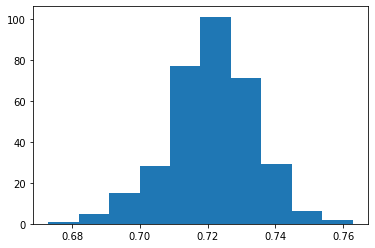

In [139]:
search_term = 'seaside boats in the ocean'
clean_search_term = clean(search_term)
search_vect = _evaluate(clean_search_term,model=my_model)
comparator = scipy.spatial.distance.cosine

# Find similarity with each puzzle
sims = []
for r_ix in range(n_reviews):
    s = comparator(rev_vects[r_ix],search_vect)
    if np.isnan(s):
        s = 0
    sims.append(s)
    
sims = np.array(sims)
# Find the max 10
best_matches = np.argsort(sims)[-10:]
best_matches = best_matches[::-1]
print('Best matches:')
print(all_product_urls[best_matches])
print(all_reviews[best_matches[0]])
print(sims[best_matches])

# pick a hard one
w = np.where(all_product_urls == 'https://amazon.com/BetterCo-Gradient-Jigsaw-Puzzle-Pieces/dp/B07P7FRSJK')[0][0]
print('Similarity for a known difficult puzzle:',sims[w])

# pick a hard one
w = np.where(all_product_urls == 'https://amazon.com/BetterCo-Gradient-Jigsaw-Puzzle-Pieces/dp/B07P7FRSJK')[0][0]
print('Similarity for a known easy puzzle:',sims[w])

plt.hist(sims[sims>0])
plt.show()